In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
BRANCH = 'r1.17.0'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
# exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=e612209b62d751d2b48fc404664cf20bc27e9bc7cc8d6f29b687b9f690e16fc9
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-7ubuntu0.1).
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following additional packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base
  libsox3
Suggested packages:
  libsox-fmt-all
The following NEW packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base
  libsox3 sox
0 upgraded, 6 newly installed, 0 to remove and 24 not upgraded.


'\nRemember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!\nAlternatively, you can uncomment the exit() below to crash and restart the kernel, in the case\nthat you want to use the "Run All Cells" (or similar) option.\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.2 MB/s eta 0:00:00


In [4]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr
import os
from datasets import load_dataset
import librosa
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

[NeMo W 2023-05-02 03:46:29 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-05-02 03:46:33 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [5]:
dataset = load_dataset('MLCommons/peoples_speech', name='test')


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

reading metadata file: 0it [00:00, ?it/s]

Dataset peoples_speech downloaded and prepared to /root/.cache/huggingface/datasets/MLCommons___peoples_speech/test/1.1.0/63840510b78b993b8d9f5e9937a1e37c3d3ec279753ab45af2b3bb67d69db973. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
print(dataset, '\n\n')
ex_filepath = dataset['test'][0]['audio']['path']
ex_text = dataset['test'][0]['text']
print(ex_filepath, '\n\n')
print(ex_text)

DatasetDict({
    test: Dataset({
        features: ['id', 'audio', 'duration_ms', 'text'],
        num_rows: 34898
    })
}) 


/root/.cache/huggingface/datasets/downloads/extracted/3db7d5bca7417e41288252c59841f11073af06c8317d82588d500d1a8a0433b0/Passive_Houses_Presentation/Passive_Houses_Presentation/Passive_Houses_Presentation_DOT_flac_00066.flac 


that's where you have a lot of windows in the south no actually that's passive solar and passive solar is something that was developed and designed in the 1960s and 70s and it was a great thing for what it was at the time but it's not a passive house


In [7]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
audio, sample_rate = librosa.load(ex_filepath)

ipd.Audio(ex_filepath, rate=sample_rate)

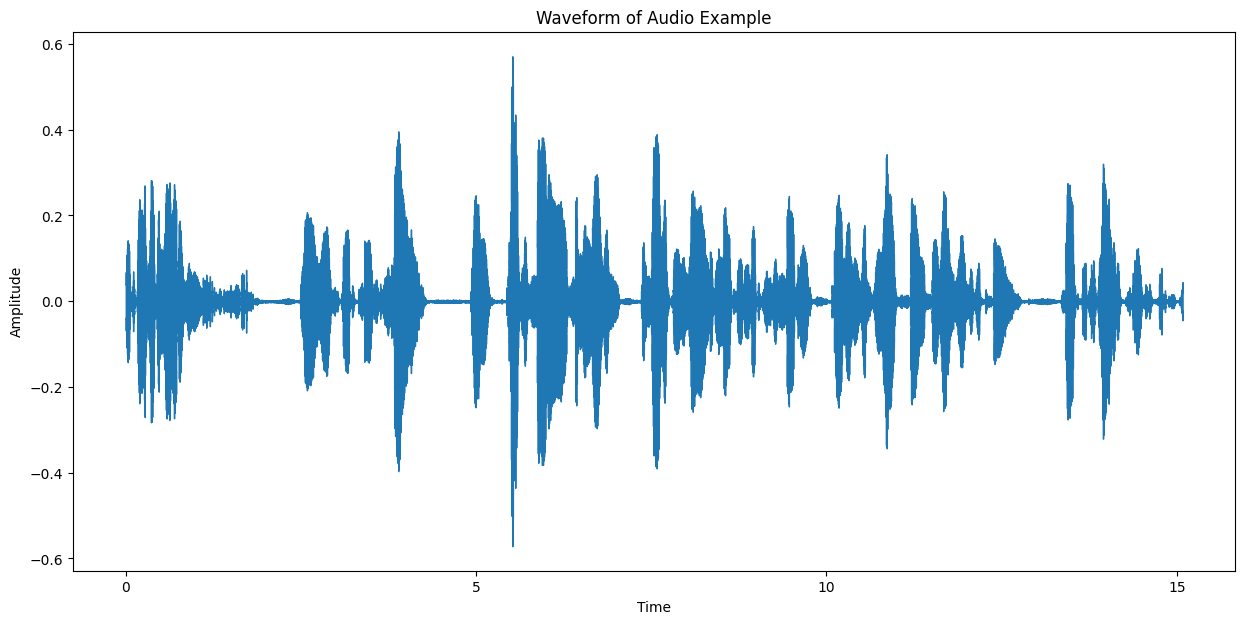

In [8]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio)

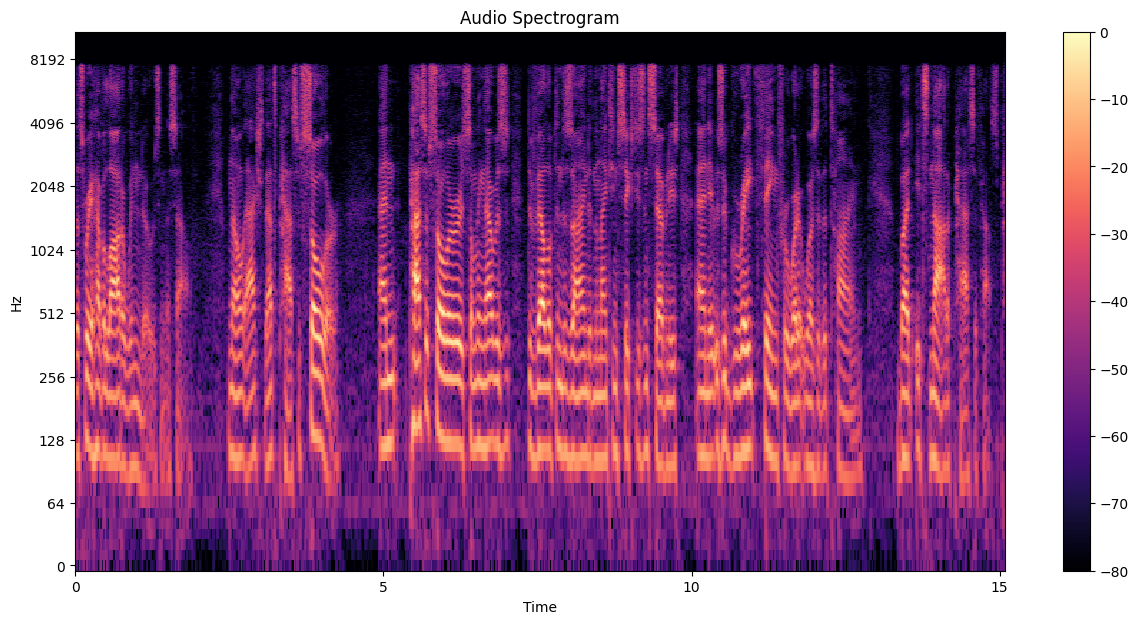

In [9]:
import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

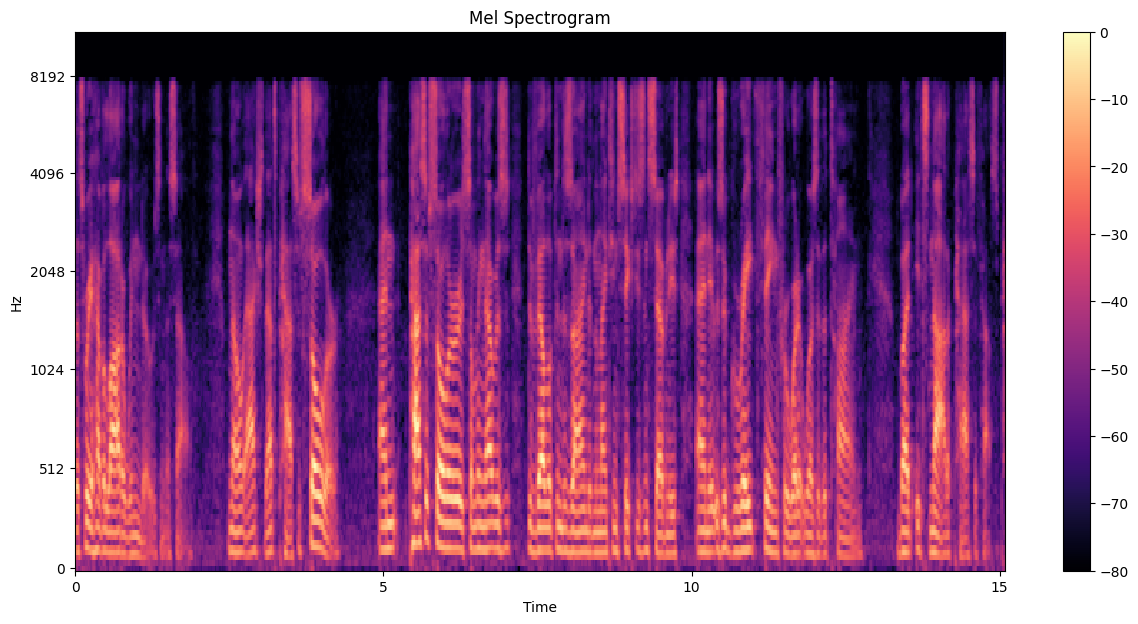

In [10]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

In [11]:
n = 10 # samples
subset_data = dataset['test'].select(range(n))
print(subset_data)

n_filepaths = [audio['path'] for audio in subset_data['audio']]
print('\n\n', n_filepaths)

n_text = subset_data['text']
print('\n\n', n_text)

Dataset({
    features: ['id', 'audio', 'duration_ms', 'text'],
    num_rows: 10
})


 ['/root/.cache/huggingface/datasets/downloads/extracted/3db7d5bca7417e41288252c59841f11073af06c8317d82588d500d1a8a0433b0/Passive_Houses_Presentation/Passive_Houses_Presentation/Passive_Houses_Presentation_DOT_flac_00066.flac', '/root/.cache/huggingface/datasets/downloads/extracted/3db7d5bca7417e41288252c59841f11073af06c8317d82588d500d1a8a0433b0/Passive_Houses_Presentation/Passive_Houses_Presentation/Passive_Houses_Presentation_DOT_flac_00102.flac', '/root/.cache/huggingface/datasets/downloads/extracted/3db7d5bca7417e41288252c59841f11073af06c8317d82588d500d1a8a0433b0/Passive_Houses_Presentation/Passive_Houses_Presentation/Passive_Houses_Presentation_DOT_flac_00149.flac', '/root/.cache/huggingface/datasets/downloads/extracted/3db7d5bca7417e41288252c59841f11073af06c8317d82588d500d1a8a0433b0/Passive_Houses_Presentation/Passive_Houses_Presentation/Passive_Houses_Presentation_DOT_flac_00381.flac', '/root/.

In [12]:
# for fname, transcription, text in zip(n_filepaths, quartznet.transcribe(paths2audio_files=n_filepaths), n_text):
#   print(f"***Audio was recognized as: {transcription}")
#   print(f'***Actual text was: {text}', '\n')

In [13]:
# --- Config Information ---#
# try:
#     from ruamel.yaml import YAML
# except ModuleNotFoundError:
#     from ruamel_yaml import YAML

# config_path = '/content/drive/MyDrive/CS 7643/Project/code/configs/conformer_transducer_bpe.yaml'
# # config_path = '/content/drive/MyDrive/CS 7643/Project/code/configs/conformer_transducer_char.yaml'

# # if not os.path.exists(config_path):
# #     # Grab the config we'll use in this example
# #     BRANCH = 'r1.17.0'
# #     !mkdir configs
# #     !wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

# yaml = YAML(typ='safe')
# with open(config_path) as f:
#     params = yaml.load(f)
# print(params)

{'name': 'Conformer-Transducer-BPE', 'model': {'sample_rate': 16000, 'compute_eval_loss': False, 'log_prediction': True, 'skip_nan_grad': False, 'model_defaults': {'enc_hidden': '${model.encoder.d_model}', 'pred_hidden': 640, 'joint_hidden': 640}, 'train_ds': {'manifest_filepath': '???', 'sample_rate': '${model.sample_rate}', 'batch_size': 16, 'shuffle': True, 'num_workers': 8, 'pin_memory': True, 'use_start_end_token': False, 'trim_silence': False, 'max_duration': 16.7, 'min_duration': 0.1, 'is_tarred': False, 'tarred_audio_filepaths': None, 'shuffle_n': 2048, 'bucketing_strategy': 'synced_randomized', 'bucketing_batch_size': None}, 'validation_ds': {'manifest_filepath': '???', 'sample_rate': '${model.sample_rate}', 'batch_size': 16, 'shuffle': False, 'num_workers': 8, 'pin_memory': True, 'use_start_end_token': False}, 'test_ds': {'manifest_filepath': None, 'sample_rate': '${model.sample_rate}', 'batch_size': 16, 'shuffle': False, 'num_workers': 8, 'pin_memory': True, 'use_start_end_t

**Transducer model config**

get training and validation data and manifests

In [14]:
train_frac = 0.8 # fraction of data to use for training
val_fac = 1 - train_frac # validation split
n_subset = 3000 # rows of data to use for training
subset_data = dataset['test'].select(range(n_subset))

nrows = subset_data.num_rows
ntrain = int(round(nrows*train_frac,0))
nval = nrows - ntrain
print(f'n training samples: {ntrain}')
print(f'n validation samples: {nval}')

train_dataset = subset_data.select(range(0, ntrain))
val_dataset = subset_data.select(range(ntrain, nrows))

# print(val_dataset)

n training samples: 2400
n validation samples: 600


**Function for manifest creation**

Define function to create a manifest .json file for the nemo models

In [15]:
import json
import os

# manifest_path='.'
# split_name='train'
# out_path = os.path.join(manifest_path, split_name+'_manifest.json')
# print(os.path.exists(out_path))

def build_manifest(dataset, manifest_path='./../data/', split_name='test', duration_unit='ms'):
    out_path = os.path.join(manifest_path, split_name+'_manifest.json')
    
    if not(os.path.exists(out_path)):
        with open(out_path, 'w') as f:
            for i,example in enumerate(dataset):
                n = dataset.num_rows
                if i%int(n/5) == 0:
                    print(f'processing sample {i} of {n} ({round(i/n*100,2)}%)')
                
                audio_path = example['audio']['path']
                transcript = example['text']
                
                assert duration_unit in ['ms','s'], '{duraction_unit should be either "ms" for millseconds or "s" for seconds}'
                if duration_unit=='ms':
                    div_by = 1000
                else:
                    div_by = 1
                metadata = {
                    'audio_filepath': audio_path,
                    'duration': example['duration_ms']/div_by,
                    'text': transcript
                }
                json.dump(metadata, f)
                f.write('\n')
    return out_path

In [16]:
new_path = '.'
train_manifest = build_manifest(train_dataset, manifest_path=new_path, split_name='train')
val_manifest = build_manifest(val_dataset, manifest_path=new_path, split_name='val')

processing sample 0 of 2400 (0.0%)
processing sample 480 of 2400 (20.0%)
processing sample 960 of 2400 (40.0%)
processing sample 1440 of 2400 (60.0%)
processing sample 1920 of 2400 (80.0%)
processing sample 0 of 600 (0.0%)
processing sample 120 of 600 (20.0%)
processing sample 240 of 600 (40.0%)
processing sample 360 of 600 (60.0%)
processing sample 480 of 600 (80.0%)


In [17]:
# params['model']['train_ds']['manifest_filepath'] = train_manifest
# params['model']['validation_ds']['manifest_filepath'] = val_manifest

## Preparing the tokenizer

Now that we have a dataset ready, we need to decide whether to use a character-based model or a sub-word-based model. For completeness' sake, we will use a tokenizer based model so that we can leverage a modern encoder architecture like ContextNet or Conformer-T.

In [18]:
if not os.path.exists("scripts/process_asr_text_tokenizer.py"):
  !wget -P scripts/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tokenizers/process_asr_text_tokenizer.py

--2023-05-02 03:52:37--  https://raw.githubusercontent.com/NVIDIA/NeMo/r1.17.0/scripts/tokenizers/process_asr_text_tokenizer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13860 (14K) [text/plain]
Saving to: ‘scripts/process_asr_text_tokenizer.py’

process_asr_text_to 100%[===================>]  13.54K  --.-KB/s    in 0s      

2023-05-02 03:52:38 (114 MB/s) - ‘scripts/process_asr_text_tokenizer.py’ saved [13860/13860]



-----

Since the dataset is tiny, we can use a small SentencePiece based tokenizer. We always delete the tokenizer directory so any changes to the manifest files are always replicated in the tokenizer.

In [19]:
VOCAB_SIZE = 100  # can be any value above 29
TOKENIZER_TYPE = "spe"  # can be wpe or spe
SPE_TYPE = "unigram"  # can be bpe or unigram

# ------------------------------------------------------------------- #
!rm -r tokenizers/

if not os.path.exists("tokenizers"):
  os.makedirs("tokenizers")

!python scripts/process_asr_text_tokenizer.py \
   --manifest=$train_manifest \
   --data_root="tokenizers" \
   --tokenizer=$TOKENIZER_TYPE \
   --spe_type=$SPE_TYPE \
   --no_lower_case \
   --log \
   --vocab_size=$VOCAB_SIZE

rm: cannot remove 'tokenizers/': No such file or directory
[NeMo W 2023-05-02 03:52:47 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
INFO:root:Finished extracting manifest : ./train_manifest.json
INFO:root:Finished extracting all manifests ! Number of sentences : 2400
[NeMo I 2023-05-02 03:52:48 sentencepiece_tokenizer:315] Processing tokenizers/text_corpus/document.txt and store at tokenizers/tokenizer_spe_unigram_v100
sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=tokenizers/text_corpus/document.txt --model_prefix=tokenizers/tokenizer_spe_unigram_v100/tokenizer --vocab_size=100 --shuffle_input_sentence=true --hard_vocab_limit=false --model_type=unigram --character_coverage=1.0 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: tokenizers/text_corpus/document.txt
  input_format: 
  model_prefix: tokenizers/tokenizer_spe_unigram_v100/tokenizer
  model_type: UNIGRAM


In [20]:
# Tokenizer path
if TOKENIZER_TYPE == 'spe':
  TOKENIZER = os.path.join("tokenizers", f"tokenizer_spe_{SPE_TYPE}_v{VOCAB_SIZE}")
  TOKENIZER_TYPE_CFG = "bpe"
else:
  TOKENIZER = os.path.join("tokenizers", f"tokenizer_wpe_v{VOCAB_SIZE}")
  TOKENIZER_TYPE_CFG = "wpe"

In [21]:
from omegaconf import DictConfig, OmegaConf, open_dict
from nemo.utils import logging, exp_manager
# params['model']['train_ds']['manifest_filepath'] = train_manifest
# params['model']['validation_ds']['manifest_filepath'] = val_manifest
# cfg = DictConfig(params)
# 'init_from_pretrained_model' in cfg

In [92]:
from nemo.collections.asr.models import EncDecRNNTModel, EncDecRNNTBPEModel

# first_asr_model = EncDecRNNTBPEModel(cfg=cfg.model, trainer=trainer)
asr_model = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(model_name="stt_en_conformer_transducer_small")

[NeMo I 2023-05-02 04:19:52 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.17.0/stt_en_conformer_transducer_small/a755afe69952642a8410330876938b83/stt_en_conformer_transducer_small.nemo.
[NeMo I 2023-05-02 04:19:52 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.17.0/stt_en_conformer_transducer_small/a755afe69952642a8410330876938b83/stt_en_conformer_transducer_small.nemo
[NeMo I 2023-05-02 04:19:52 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2023-05-02 04:19:53 mixins:170] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2023-05-02 04:19:54 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/nemo_asr_set_2.0/RES/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 16
    shuffle: true
    num_workers: 4
    pin_memory: true
    use_start_end_token: true
    trim_silence: false
    max_duration: 20
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data2/nemo_asr_set_2.0/RES/audio__OP_0..4095_CL_.tar
    
[NeMo W 2023-05-02 04:19:54 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /manifests/librispeech/librivox-dev-other.json
    - /manifest

[NeMo I 2023-05-02 04:19:54 features:287] PADDING: 0


[NeMo W 2023-05-02 04:19:54 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
      warnings.warn("dropout option adds dropout after all but last "
    


[NeMo I 2023-05-02 04:19:55 rnnt_models:206] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0}
[NeMo I 2023-05-02 04:19:55 save_restore_connector:247] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.17.0/stt_en_conformer_transducer_small/a755afe69952642a8410330876938b83/stt_en_conformer_transducer_small.nemo.


In [93]:
import copy
cfg = copy.deepcopy(asr_model.cfg)

In [94]:
with open_dict(cfg):    
  # Train dataset
  cfg.train_ds.manifest_filepath = train_manifest
  cfg.train_ds.is_tarred = False
  cfg.train_ds.tarred_audio_filepaths = None
  cfg.train_ds.batch_size = 4
  cfg.train_ds.num_workers = 2
  cfg.train_ds.pin_memory = True
  cfg.train_ds.trim_silence = True

  # validation
  cfg.validation_ds.manifest_filepath = val_manifest
  cfg.validation_ds.batch_size = 4
  cfg.validation_ds.num_workers = 2
  cfg.validation_ds.pin_memory = True
  cfg.validation_ds.trim_silence = True

  # test
  cfg.test_ds.manifest_filepath = None

In [95]:
# setup data loaders with new configs
asr_model.setup_training_data(cfg.train_ds)
asr_model.setup_validation_data(cfg.validation_ds)
asr_model.setup_test_data(cfg.test_ds)

[NeMo I 2023-05-02 04:20:05 collections:193] Dataset loaded with 2371 files totalling 3.63 hours
[NeMo I 2023-05-02 04:20:05 collections:194] 29 files were filtered totalling 0.20 hours
[NeMo I 2023-05-02 04:20:05 collections:193] Dataset loaded with 600 files totalling 1.03 hours
[NeMo I 2023-05-02 04:20:05 collections:194] 0 files were filtered totalling 0.00 hours


[NeMo W 2023-05-02 04:20:05 audio_to_text_dataset:647] Could not load dataset as `manifest_filepath` was None. Provided config : {'manifest_filepath': None, 'sample_rate': 16000, 'batch_size': 16, 'shuffle': False, 'num_workers': 8, 'pin_memory': True, 'use_start_end_token': True, 'is_tarred': False, 'tarred_audio_filepaths': 'na'}


In [96]:
with open_dict(asr_model.cfg.optim):
  asr_model.cfg.optim.lr = 0.01
  asr_model.cfg.optim.betas = [0.95, 0.5]  # from paper
  asr_model.cfg.optim.weight_decay = 0.001  # Original weight decay
  asr_model.cfg.optim.sched.warmup_steps = None  # Remove default number of steps of warmup
  asr_model.cfg.optim.sched.warmup_ratio = 0.05  # 5 % warmup
  asr_model.cfg.optim.sched.min_lr = 1e-5

In [108]:
import pytorch_lightning as pl
import torch

if torch.cuda.is_available():
  accelerator = 'gpu'
else:
  accelerator = 'cpu'

epochs = 20

trainer = pl.Trainer(devices=1, max_epochs=epochs, accelerator=accelerator,
                      accumulate_grad_batches=1,
                      enable_checkpointing=False,
                      logger=False,
                      log_every_n_steps=10,
                      check_val_every_n_epoch=1,
                     precision=32,
                     num_sanity_val_steps=0)

asr_model.set_trainer(trainer)

# update internal config
asr_model.cfg = asr_model._cfg

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [109]:
# asr_model.cfg
config = exp_manager.ExpManagerConfig(
    name="ASR-conformer-transd",
    create_tensorboard_logger=True,
    create_checkpoint_callback=True,
    checkpoint_callback_params=exp_manager.CallbackParams(
        monitor="val_wer",
        mode="min",
        always_save_nemo=True,
        save_best_model=True,
    ),
)


# config = exp_manager.ExpManagerConfig(
#     create_tensorboard_logger=False
# )


config = OmegaConf.structured(config)

logdir = exp_manager.exp_manager(trainer, config)

[NeMo I 2023-05-02 04:33:14 exp_manager:370] Experiments will be logged at /content/nemo_experiments/ASR-conformer-transd/2023-05-02_03-53-43
[NeMo I 2023-05-02 04:33:14 exp_manager:788] TensorboardLogger has been set up


With that, we can start training with just one line!

In [110]:
# torch.cuda.memory_summary(device=None, abbreviated=False)
# torch.cuda.empty_cache()
# import gc
# del variables
# gc.collect()

In [ ]:
# Start training!!!
trainer.fit(asr_model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2023-05-02 04:33:18 modelPT:722] Optimizer config = AdamW (
    Parameter Group 0
        amsgrad: False
        betas: [0.95, 0.5]
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 0.01
        maximize: False
        weight_decay: 0.001
    )
[NeMo I 2023-05-02 04:33:18 lr_scheduler:910] Scheduler "<nemo.core.optim.lr_scheduler.NoamAnnealing object at 0x7f57dbff62c0>" 
    will be used during training (effective maximum steps = 11860) - 
    Parameters : 
    (d_model: 176
    warmup_steps: null
    warmup_ratio: 0.05
    min_lr: 1.0e-05
    max_steps: 11860
    )


INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConformerEncoder                  | 13.0 M
2 | decoder           | RNNTDecoder                       | 1.1 M 
3 | joint             | RNNTJoint                         | 488 K 
4 | loss              | RNNTLoss                          | 0     
5 | spec_augmentation | SpectrogramAugmentation           | 0     
6 | wer               | RNNTBPEWER                        | 0     
------------------------------------------------------------------------
14.6 M    Trainable params
0         Non-trainable params
14.6 M    Total params
58.443    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f58ac80ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f58ac80ec20>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f58ac80ec20>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/pyt

[NeMo I 2023-05-02 04:33:26 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:33:26 rnnt_wer_bpe:395] reference :my payback if i'm looking at oil which is what it'll replace is somewhere on the order of ten to thirteen years depending on that's where the two increase in oil cause i wanted to be conservative
[NeMo I 2023-05-02 04:33:26 rnnt_wer_bpe:396] predicted :pay which is going th depend depend depend depend depends with a two hundred and
[NeMo I 2023-05-02 04:33:30 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:33:30 rnnt_wer_bpe:395] reference :the first five are energy star houses
[NeMo I 2023-05-02 04:33:30 rnnt_wer_bpe:396] predicted :first five energy start
[NeMo I 2023-05-02 04:33:32 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:33:32 rnnt_wer_bpe:395] reference :i generally favor small neighborhood daycare
[NeMo I 2023-05-02 04:33:32 rnnt_wer_bpe:396] predicted :general fa
[NeMo I 2023-05-02 04:33:35 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:33:35 rnnt_wer_bpe:395] reference

[NeMo W 2023-05-02 04:36:30 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
      warn(NumbaPerformanceWarning(msg))
    


Validation: 0it [00:00, ?it/s]

[NeMo I 2023-05-02 04:36:31 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:36:31 rnnt_wer_bpe:395] reference :and there's evidence that his partner is africanamerican and defendant in this case and the video would submit that it was not someone who was africanamerican
[NeMo I 2023-05-02 04:36:31 rnnt_wer_bpe:396] predicted :there was evidenceence that his afric and defden in this case and the video would sub that it was not someone who is african america
[NeMo I 2023-05-02 04:36:32 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:36:32 rnnt_wer_bpe:395] reference :he was there
[NeMo I 2023-05-02 04:36:32 rnnt_wer_bpe:396] predicted :he was he was there
[NeMo I 2023-05-02 04:36:33 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:36:33 rnnt_wer_bpe:395] reference :you've got it's the middle of the night there is clearly a fire that occurred in the stairwell absolutely everyone agrees to that set by an unknown person and a neighbor identifies this defendant as being the likely person who started

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 593: 'val_wer' reached 0.63557 (best 0.63557), saving model to '/content/nemo_experiments/ASR-conformer-transd/2023-05-02_03-53-43/checkpoints/ASR-conformer-transd--val_wer=0.6356-epoch=0.ckpt' as top 3


[NeMo I 2023-05-02 04:37:47 exp_manager:963] New best .nemo model saved to: /content/nemo_experiments/ASR-conformer-transd/2023-05-02_03-53-43/checkpoints/ASR-conformer-transd.nemo
[NeMo I 2023-05-02 04:37:52 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:37:52 rnnt_wer_bpe:395] reference :my sorry hrv heat recovery ventilation
[NeMo I 2023-05-02 04:37:52 rnnt_wer_bpe:396] predicted :sorry he recover that was that
[NeMo I 2023-05-02 04:37:54 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:37:54 rnnt_wer_bpe:395] reference :i'm getting that fresh air in my house
[NeMo I 2023-05-02 04:37:54 rnnt_wer_bpe:396] predicted :i'm getting in my house
[NeMo I 2023-05-02 04:37:57 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:37:57 rnnt_wer_bpe:395] reference :and then we also received a letter this afternoon from miss claire stone expressing opposition
[NeMo I 2023-05-02 04:37:57 rnnt_wer_bpe:396] predicted :and he also this after from this fair sting
[NeMo I 2023-05-02 04:37:59 rnnt_wer_bpe:394] 
  

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-05-02 04:40:57 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:40:57 rnnt_wer_bpe:395] reference :and there's evidence that his partner is africanamerican and defendant in this case and the video would submit that it was not someone who was africanamerican
[NeMo I 2023-05-02 04:40:57 rnnt_wer_bpe:396] predicted :there was evit his africaneric and defen in this case and the video would sub that it was not someone who is afric
[NeMo I 2023-05-02 04:40:58 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:40:58 rnnt_wer_bpe:395] reference :he was there
[NeMo I 2023-05-02 04:40:58 rnnt_wer_bpe:396] predicted :he was he was there
[NeMo I 2023-05-02 04:40:59 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:40:59 rnnt_wer_bpe:395] reference :you've got it's the middle of the night there is clearly a fire that occurred in the stairwell absolutely everyone agrees to that set by an unknown person and a neighbor identifies this defendant as being the likely person who started the fire after wa

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1186: 'val_wer' reached 0.61264 (best 0.61264), saving model to '/content/nemo_experiments/ASR-conformer-transd/2023-05-02_03-53-43/checkpoints/ASR-conformer-transd--val_wer=0.6126-epoch=1.ckpt' as top 3


[NeMo I 2023-05-02 04:42:13 exp_manager:963] New best .nemo model saved to: /content/nemo_experiments/ASR-conformer-transd/2023-05-02_03-53-43/checkpoints/ASR-conformer-transd.nemo
[NeMo I 2023-05-02 04:42:16 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:42:16 rnnt_wer_bpe:395] reference :this is the west elevation the east elevation and the north elevation
[NeMo I 2023-05-02 04:42:16 rnnt_wer_bpe:396] predicted :the west elevation and the east and the north
[NeMo I 2023-05-02 04:42:19 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:42:19 rnnt_wer_bpe:395] reference :at least that's what i heard from the engineer when i met with them they can control visibly with the dark sky laws you know so when they install it you know they'll come out at night and they'll fix it
[NeMo I 2023-05-02 04:42:19 rnnt_wer_bpe:396] predicted :at least you have with axosy they'll fi it
[NeMo I 2023-05-02 04:42:22 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:42:22 rnnt_wer_bpe:395] reference :and this to me i

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-05-02 04:45:22 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:45:22 rnnt_wer_bpe:395] reference :and there's evidence that his partner is africanamerican and defendant in this case and the video would submit that it was not someone who was africanamerican
[NeMo I 2023-05-02 04:45:22 rnnt_wer_bpe:396] predicted :and there was evitnor is african and defendant in this case and the video would sub that it was not someone who is afric
[NeMo I 2023-05-02 04:45:23 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:45:23 rnnt_wer_bpe:395] reference :he was there
[NeMo I 2023-05-02 04:45:23 rnnt_wer_bpe:396] predicted :he was he was there
[NeMo I 2023-05-02 04:45:24 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:45:24 rnnt_wer_bpe:395] reference :you've got it's the middle of the night there is clearly a fire that occurred in the stairwell absolutely everyone agrees to that set by an unknown person and a neighbor identifies this defendant as being the likely person who started the fire af

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1779: 'val_wer' reached 0.57678 (best 0.57678), saving model to '/content/nemo_experiments/ASR-conformer-transd/2023-05-02_03-53-43/checkpoints/ASR-conformer-transd--val_wer=0.5768-epoch=2.ckpt' as top 3


[NeMo I 2023-05-02 04:46:36 exp_manager:963] New best .nemo model saved to: /content/nemo_experiments/ASR-conformer-transd/2023-05-02_03-53-43/checkpoints/ASR-conformer-transd.nemo
[NeMo I 2023-05-02 04:46:39 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:46:39 rnnt_wer_bpe:395] reference :here's my house here's my deck
[NeMo I 2023-05-02 04:46:39 rnnt_wer_bpe:396] predicted :here's my house here my deckck
[NeMo I 2023-05-02 04:46:43 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:46:43 rnnt_wer_bpe:395] reference :eliminate thermal bridging
[NeMo I 2023-05-02 04:46:43 rnnt_wer_bpe:396] predicted :eliminateate thermoing
[NeMo I 2023-05-02 04:46:47 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:46:47 rnnt_wer_bpe:395] reference :i was here
[NeMo I 2023-05-02 04:46:47 rnnt_wer_bpe:396] predicted :i was here
[NeMo I 2023-05-02 04:46:50 rnnt_wer_bpe:394] 
    
[NeMo I 2023-05-02 04:46:50 rnnt_wer_bpe:395] reference :i don't know if we have to introduce chris because he's got his credentials up

In [ ]:
try:
  from google import colab
  COLAB_ENV = True
except (ImportError, ModuleNotFoundError):
  COLAB_ENV = False

# Load the TensorBoard notebook extension
if COLAB_ENV:
  %load_ext tensorboard
  %tensorboard --logdir /content/experiments/ASR-conformer-transd/
else:
  print("To use tensorboard, please use this notebook in a Google Colab environment.")

evaluate word error rate on model

In [ ]:
from nemo.collections.asr.metrics.wer import word_error_rate

def predict_sentences(model_name, test_set = val_dataset):
  asr_model = nemo_asr.models.ASRModel.from_pretrained(model_name=model_name) 

  raw_transcripts = []
  paths = []
  for i in range(600):
    raw_transcripts.append(test_set[i]['text'])
    paths.append(test_set[i]['audio']['path'])

  pred_transcripts = asr_model.transcribe(paths)
  if isinstance(pred_transcripts, tuple):
    pred_transcripts = pred_transcripts[0]
  wer = word_error_rate(pred_transcripts, raw_transcripts)

  return wer

predict_sentences('stt_en_conformer_transducer_xxlarge', val_dataset)

[NeMo I 2023-05-01 04:26:52 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_conformer_transducer_xxlarge/versions/1.8.0/files/stt_en_conformer_transducer_xxlarge.nemo to /root/.cache/torch/NeMo/NeMo_1.17.0/stt_en_conformer_transducer_xxlarge/93d726fd6f5c94736ec0696bb20b1d6a/stt_en_conformer_transducer_xxlarge.nemo
[NeMo I 2023-05-01 04:28:15 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2023-05-01 04:28:59 mixins:170] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2023-05-01 04:29:00 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/NeMo_ASR_SET/English/v2.0/train/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 8
    shuffle: true
    num_workers: 4
    pin_memory: true
    use_start_end_token: true
    trim_silence: false
    max_duration: 20
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/NeMo_ASR_SET/English/v2.0/train/audio__OP_0..4095_CL_.tar
    
[NeMo W 2023-05-01 04:29:00 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /data/librispeech_withsp2/manifests/librivo

[NeMo I 2023-05-01 04:29:00 features:287] PADDING: 0
[NeMo I 2023-05-01 04:29:09 rnnt_models:206] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0}
[NeMo I 2023-05-01 04:29:27 save_restore_connector:247] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.17.0/stt_en_conformer_transducer_xxlarge/93d726fd6f5c94736ec0696bb20b1d6a/stt_en_conformer_transducer_xxlarge.nemo.


Transcribing:   0%|          | 0/150 [00:00<?, ?it/s]

0.3095425093265266

There we go! We've put together a full training pipeline for the model and trained it for 50 epochs.

If you'd like to save this model checkpoint for loading later (e.g. for fine-tuning, or for continuing training), you can simply call `first_asr_model.save_to(<checkpoint_path>)`. Then, to restore your weights, you can rebuild the model using the config (let's say you call it `first_asr_model_continued` this time) and call `first_asr_model_continued.restore_from(<checkpoint_path>)`.

# <font color='red'><u>NOTHING CHANGED BELOW THIS POINT BY JOHNNIE YET</u></font>

### After Training: Monitoring Progress and Changing Hyperparameters
We can  now start Tensorboard to see how training went. Recall that WER stands for Word Error Rate and so the lower it is, the better.

We could improve this model by playing with hyperparameters. We can look at the current hyperparameters with the following:

In [ ]:
print(params['model']['optim'])

{'name': 'novograd', 'lr': 0.01, 'betas': [0.8, 0.5], 'weight_decay': 0.001, 'sched': {'name': 'CosineAnnealing', 'monitor': 'val_loss', 'reduce_on_plateau': False, 'warmup_steps': None, 'warmup_ratio': None, 'min_lr': 0.0, 'last_epoch': -1}}


In [ ]:
# print(first_asr_model.parameters)

Let's say we wanted to change the learning rate. To do so, we can create a `new_opt` dict and set our desired learning rate, then call `<model>.setup_optimization()` with the new optimization parameters.

In [ ]:
import copy
new_opt = copy.deepcopy(params['model']['optim'])
new_opt['lr'] = 0.001
first_asr_model.setup_optimization(optim_config=DictConfig(new_opt))
# And then you can invoke trainer.fit(first_asr_model)

[NeMo I 2023-04-29 22:25:36 modelPT:722] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )
[NeMo I 2023-04-29 22:25:36 lr_scheduler:910] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f1ab1703af0>" 
    will be used during training (effective maximum steps = 3750) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 3750
    )


(Novograd (
 Parameter Group 0
     amsgrad: False
     betas: [0.8, 0.5]
     eps: 1e-08
     grad_averaging: False
     initial_lr: 0.001
     lr: 0.001
     weight_decay: 0.001
 ),
 {'scheduler': <nemo.core.optim.lr_scheduler.CosineAnnealing at 0x7f1ab1703af0>,
  'interval': 'step',
  'frequency': 1,
  'monitor': 'val_loss',
  'reduce_on_plateau': False})

## Inference

Let's have a quick look at how one could run inference with NeMo's ASR model.

First, ``EncDecCTCModel`` and its subclasses contain a handy ``transcribe`` method which can be used to simply obtain audio files' transcriptions. It also has batch_size argument to improve performance.

In [ ]:
for fname, transcription, text in zip(n_filepaths, first_asr_model.transcribe(paths2audio_files=n_filepaths), n_text):
  print(f"***Audio was recognized as: {transcription}")
  print(f'***Actual text was: {text}', '\n')

Transcribing:   0%|          | 0/3 [00:00<?, ?it/s]

***Audio was recognized as: ththat's whora have a lot o winosin ti sn act tatt pasev soar and passive soera someting that was tove lod din tesin en i tin six ciusin sevens and it was a grat thingfor wti was at the toi but eitnoot a passive hous
***Actual text was: that's where you have a lot of windows in the south no actually that's passive solar and passive solar is something that was developed and designed in the 1960s and 70s and it was a great thing for what it was at the time but it's not a passive house 

***Audio was recognized as: i was pas i hlos lhejus l sesion
***Actual text was: that was passed in the last legislative session 

***Audio was recognized as: they com pleck ralhey hard to getsto
***Actual text was: very complex really hard to get through 

***Audio was recognized as: this is a pas thouse
***Actual text was: this is a passive house 

***Audio was recognized as: th had a y ronnoeadting o baase por heating
***Actual text was: i had a hydronic heating or baseboard

Below is an example of a simple inference loop in pure PyTorch. It also shows how one can compute Word Error Rate (WER) metric between predictions and references.

In [ ]:
# Bigger batch-size = bigger throughput
params['model']['validation_ds']['batch_size'] = 16

# Setup the test data loader and make sure the model is on GPU
first_asr_model.setup_test_data(test_data_config=params['model']['validation_ds'])
first_asr_model.cuda()
first_asr_model.eval()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in first_asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = first_asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        first_asr_model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = first_asr_model._wer.compute()
        first_asr_model._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        # Release tensors from GPU memory
        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

This WER is not particularly impressive and could be significantly improved. You could train longer (try 100 epochs) to get a better number. Check out the next section on how to improve it further.

## Model Improvements

You already have all you need to create your own ASR model in NeMo, but there are a few more tricks that you can employ if you so desire. In this section, we'll briefly cover a few possibilities for improving an ASR model.

### Data Augmentation

There exist several ASR data augmentation methods that can increase the size of our training set.

For example, we can perform augmentation on the spectrograms by zeroing out specific frequency segments ("frequency masking") or time segments ("time masking") as described by [SpecAugment](https://arxiv.org/abs/1904.08779), or zero out rectangles on the spectrogram as in [Cutout](https://arxiv.org/pdf/1708.04552.pdf). In NeMo, we can do all three of these by simply adding in a `SpectrogramAugmentation` neural module. (As of now, it does not perform the time warping from the SpecAugment paper.)

Our toy model does not do spectrogram augmentation. But the real one we got from cloud does:

In [ ]:
print(quartznet._cfg['spec_augment'])

If you want to enable SpecAugment in your model, make sure your .yaml config file contains 'model/spec_augment' section which looks like the one above.

### Transfer learning

Transfer learning is an important machine learning technique that uses a model’s knowledge of one task to make it perform better on another. Fine-tuning is one of the techniques to perform transfer learning. It is an essential part of the recipe for many state-of-the-art results where a base model is first pretrained on a task with abundant training data and then fine-tuned on different tasks of interest where the training data is less abundant or even scarce.

In ASR you might want to do fine-tuning in multiple scenarios, for example, when you want to improve your model's performance on a particular domain (medical, financial, etc.) or on accented speech. You can even transfer learn from one language to another! Check out [this paper](https://arxiv.org/abs/2005.04290) for examples.

Transfer learning with NeMo is simple. Let's demonstrate how the model we got from the cloud could be fine-tuned on AN4 data. (NOTE: this is a toy example). And, while we are at it, we will change model's vocabulary, just to demonstrate how it's done.

In [ ]:
# Check what kind of vocabulary/alphabet the model has right now
print(quartznet.decoder.vocabulary)

# Let's add "!" symbol there. Note that you can (and should!) change the vocabulary
# entirely when fine-tuning using a different language.
quartznet.change_vocabulary(
    new_vocabulary=[
        ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
        'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", "!"
    ]
)

After this, our decoder has completely changed, but our encoder (which is where most of the weights are) remained intact. Let's fine tune-this model for 2 epochs on AN4 dataset. We will also use the smaller learning rate from ``new_opt` (see the "After Training" section)`.

In [ ]:
# Use the smaller learning rate we set before
quartznet.setup_optimization(optim_config=DictConfig(new_opt))

# Point to the data we'll use for fine-tuning as the training set
quartznet.setup_training_data(train_data_config=params['model']['train_ds'])

# Point to the new validation data for fine-tuning
quartznet.setup_validation_data(val_data_config=params['model']['validation_ds'])

# And now we can create a PyTorch Lightning trainer and call `fit` again.
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=2)
trainer.fit(quartznet)

### Fast Training

Last but not least, we could simply speed up training our model! If you have the resources, you can speed up training by splitting the workload across multiple GPUs. Otherwise (or in addition), there's always mixed precision training, which allows you to increase your batch size.

You can use [PyTorch Lightning's Trainer object](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html?highlight=Trainer) to handle mixed-precision and distributed training for you. Below are some examples of flags you would pass to the `Trainer` to use these features:

```python
# Mixed precision:
trainer = pl.Trainer(amp_level='O1', precision=16)

# Trainer with a distributed backend:
trainer = pl.Trainer(devices=2, num_nodes=2, accelerator='gpu', strategy='ddp')

# Of course, you can combine these flags as well.
```

Finally, have a look at [example scripts in NeMo repository](https://github.com/NVIDIA/NeMo/blob/stable/examples/asr/asr_ctc/speech_to_text_ctc.py) which can handle mixed precision and distributed training using command-line arguments.

### Deployment

Note: It is recommended to run the deployment code from the NVIDIA PyTorch container.

Let's get back to our pre-trained model and see how easy it can be exported to an ONNX file
in order to run it in an inference engine like TensorRT or ONNXRuntime.

If you are running in an environment outside of the NVIDIA PyTorch container (like Google Colab for example) then you will have to build the onnxruntime and onnxruntime-gpu. The cell below gives an example of how to build those runtimes but the example may have to be adapted depending on your environment.

In [ ]:
!pip install --upgrade onnxruntime # for gpu, use onnxruntime-gpu
#!mkdir -p ort
#%cd ort
#!git clean -xfd
#!git clone --depth 1 --branch v1.8.0 https://github.com/microsoft/onnxruntime.git .
#!./build.sh --skip_tests --config Release --build_shared_lib --parallel --use_cuda --cuda_home /usr/local/cuda --cudnn_home /usr/lib/#x86_64-linux-gnu --build_wheel
#!pip uninstall -y onnxruntime
#!pip uninstall -y onnxruntime-gpu
#!pip install  --upgrade --force-reinstall ./build/Linux/Release/dist/onnxruntime*.whl
#%cd ..

Then run

In [ ]:
import json
import os
import tempfile
import onnxruntime
import torch

import numpy as np
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.data.audio_to_text import AudioToCharDataset
from nemo.collections.asr.metrics.wer import WER

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def setup_transcribe_dataloader(cfg, vocabulary):
    config = {
        'manifest_filepath': os.path.join(cfg['temp_dir'], 'manifest.json'),
        'sample_rate': 16000,
        'labels': vocabulary,
        'batch_size': min(cfg['batch_size'], len(cfg['paths2audio_files'])),
        'trim_silence': True,
        'shuffle': False,
    }
    dataset = AudioToCharDataset(
        manifest_filepath=config['manifest_filepath'],
        labels=config['labels'],
        sample_rate=config['sample_rate'],
        int_values=config.get('int_values', False),
        augmentor=None,
        max_duration=config.get('max_duration', None),
        min_duration=config.get('min_duration', None),
        max_utts=config.get('max_utts', 0),
        blank_index=config.get('blank_index', -1),
        unk_index=config.get('unk_index', -1),
        normalize=config.get('normalize_transcripts', False),
        trim=config.get('trim_silence', True),
        parser=config.get('parser', 'en'),
    )
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=config['batch_size'],
        collate_fn=dataset.collate_fn,
        drop_last=config.get('drop_last', False),
        shuffle=False,
        num_workers=config.get('num_workers', 0),
        pin_memory=config.get('pin_memory', False),
    )

quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

quartznet.export('qn.onnx')

ort_session = onnxruntime.InferenceSession('qn.onnx', providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])

with tempfile.TemporaryDirectory() as tmpdir:
    with open(os.path.join(tmpdir, 'manifest.json'), 'w') as fp:
        for audio_file in files:
            entry = {'audio_filepath': audio_file, 'duration': 100000, 'text': 'nothing'}
            fp.write(json.dumps(entry) + '\n')

    config = {'paths2audio_files': files, 'batch_size': 4, 'temp_dir': tmpdir}
    temporary_datalayer = setup_transcribe_dataloader(config, quartznet.decoder.vocabulary)
    for test_batch in temporary_datalayer:
        processed_signal, processed_signal_len = quartznet.preprocessor(
            input_signal=test_batch[0].to(quartznet.device), length=test_batch[1].to(quartznet.device)
        )
        ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(processed_signal),}
        ologits = ort_session.run(None, ort_inputs)
        alogits = np.asarray(ologits)
        logits = torch.from_numpy(alogits[0])
        greedy_predictions = logits.argmax(dim=-1, keepdim=False)
        wer = WER(decoding=quartznet.decoding, use_cer=False)
        hypotheses, _ = wer.decoding.ctc_decoder_predictions_tensor(greedy_predictions)
        print(hypotheses)
        break


## Under the Hood

NeMo is open-source and we do all our model development in the open, so you can inspect our code if you wish.

In particular, ``nemo_asr.model.EncDecCTCModel`` is an encoder-decoder model which is constructed using several ``Neural Modules`` taken from ``nemo_asr.modules.`` Here is what its forward pass looks like:
```python
def forward(self, input_signal, input_signal_length):
    processed_signal, processed_signal_len = self.preprocessor(
        input_signal=input_signal, length=input_signal_length,
    )
    # Spec augment is not applied during evaluation/testing
    if self.spec_augmentation is not None and self.training:
        processed_signal = self.spec_augmentation(input_spec=processed_signal)
    encoded, encoded_len = self.encoder(audio_signal=processed_signal, length=processed_signal_len)
    log_probs = self.decoder(encoder_output=encoded)
    greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)
    return log_probs, encoded_len, greedy_predictions
```
Here:

* ``self.preprocessor`` is an instance of ``nemo_asr.modules.AudioToMelSpectrogramPreprocessor``, which is a neural module that takes audio signal and converts it into a Mel-Spectrogram
* ``self.spec_augmentation`` - is a neural module of type ```nemo_asr.modules.SpectrogramAugmentation``, which implements data augmentation. 
* ``self.encoder`` - is a convolutional Jasper/QuartzNet-like encoder of type ``nemo_asr.modules.ConvASREncoder``
* ``self.decoder`` - is a ``nemo_asr.modules.ConvASRDecoder`` which simply projects into the target alphabet (vocabulary).

Also, ``EncDecCTCModel`` uses the audio dataset class ``nemo_asr.data.AudioToCharDataset`` and CTC loss implemented in ``nemo_asr.losses.CTCLoss``.

You can use these and other neural modules (or create new ones yourself!) to construct new ASR models.

# Further Reading/Watching:

That's all for now! If you'd like to learn more about the topics covered in this tutorial, here are some resources that may interest you:
- [Stanford Lecture on ASR](https://www.youtube.com/watch?v=3MjIkWxXigM)
- ["An Intuitive Explanation of Connectionist Temporal Classification"](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)
- [Explanation of CTC with Prefix Beam Search](https://medium.com/corti-ai/ctc-networks-and-language-models-prefix-beam-search-explained-c11d1ee23306)
- [Listen Attend and Spell Paper (seq2seq ASR model)](https://arxiv.org/abs/1508.01211)
- [Explanation of the mel spectrogram in more depth](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0)
- [Jasper Paper](https://arxiv.org/abs/1904.03288)
- [QuartzNet paper](https://arxiv.org/abs/1910.10261)
- [SpecAugment Paper](https://arxiv.org/abs/1904.08779)
- [Explanation and visualization of SpecAugment](https://towardsdatascience.com/state-of-the-art-audio-data-augmentation-with-google-brains-specaugment-and-pytorch-d3d1a3ce291e)
- [Cutout Paper](https://arxiv.org/pdf/1708.04552.pdf)
- [Transfer Learning Blogpost](https://developer.nvidia.com/blog/jump-start-training-for-speech-recognition-models-with-nemo/)